# Работа в Spark

## Установки и библиотеки

In [ ]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip &> /dev/null
!unzip ngrok-stable-linux-amd64.zip &> /dev/null
get_ipython().system_raw('./ngrok http 4050 &')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import gdown
import concurrent.futures
import glob
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max as spark_max, mean
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from functools import reduce

In [ ]:
# Ссылка на датасет
url_data = 'https://drive.google.com/file/d/1x4nxZi8J6frCV4ck3tKlsiHZ2nGn2NC0'
file_id_data = '1x4nxZi8J6frCV4ck3tKlsiHZ2nGn2NC0'
download_url_data = f'https://drive.google.com/uc?id={file_id_data}'

# Ссылка на таргет
url_target = 'https://drive.google.com/file/d/1ASaCZJ8RaOirwA8c-14f09GfT9jgb7GV'
file_id_target = '1ASaCZJ8RaOirwA8c-14f09GfT9jgb7GV'
download_url_target = f'https://drive.google.com/uc?id={file_id_target}'

# Папка скачивания
output = '/content/'  # Укажите нужное имя файла, например 'your_file.zip'

# Скачивание файла
gdown.download(download_url_data, output, quiet=False)
gdown.download(download_url_target, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1x4nxZi8J6frCV4ck3tKlsiHZ2nGn2NC0
From (redirected): https://drive.google.com/uc?id=1x4nxZi8J6frCV4ck3tKlsiHZ2nGn2NC0&confirm=t&uuid=234a4a97-21fb-401a-a17c-5dc34168f875
To: /content/train_data.zip
100%|██████████| 319M/319M [00:01<00:00, 168MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ASaCZJ8RaOirwA8c-14f09GfT9jgb7GV
To: /content/train_target.csv
100%|██████████| 28.9M/28.9M [00:00<00:00, 185MB/s]


'/content/train_target.csv'

In [ ]:
# Путь, куда вы хотите извлечь файлы
extract_to = '/content'
!unzip -q -o train_data.zip  -d {extract_to}

# Загрузка датасета из файлов датасета в формате Parquet

In [ ]:
%%time
# Инициализация SparkSession с настройкой для корректного отображения колонок
# Инициализация SparkSession
# Инициализация SparkSession с увеличенной памятью и другими оптимизированными настройками
spark = SparkSession.builder \
    .appName("Combine and Sort Parquet Files") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memoryOverhead", "1g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.network.timeout", "600s") \
    .getOrCreate()

# Указываем путь к директории с файлами .parquet
# directory_path = 'C:/Users/Tokar/Skillbox MJ Junior/Итоговая работа/train_data/train_data'
# Получаем список всех файлов с расширением .pq в указанной директории
directory_path = '/content/train_data'
file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.pq')]

# Создаем пустой список для хранения DataFrame'ов
dataframes = []

# Читаем каждый файл parquet и добавляем DataFrame в список
for file_path in file_paths:
    df = spark.read.parquet(file_path)
    dataframes.append(df)

# Функция для объединения всех DataFrame в один
def unionAll(dfs):
    return reduce(lambda df1, df2: df1.unionByName(df2, allowMissingColumns=True), dfs)

# Объединяем все DataFrame'ы в один
combined_df = unionAll(dataframes) if dataframes else None

# Сортировка объединенного DataFrame по 'id' в порядке возрастания
combined_df.orderBy('id').show()

+---+---+----------------+-------------------+---------+---------+---------------+---------------+----------------------+-----------------------+---------------------+-----------------------+-------------------------+--------------------------+----------+------------+-------------+-------------+-----------+--------------+----------------+-----------------+-----------------+---------------+--------+--------------+-----------------+------------+------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------------------------+-----------------------+---------------------+---------------------+-----------+-----------+
| id| rn|pre_since_opened|pre_since_confirmed|pre_pterm|pre_fterm|pre_till_pclose|pre_till_fclose|p

In [ ]:
# Вывод общего количества строк датафрейма
row_count = combined_df.count()
print(f'Общее количество строк датафрейма: {row_count}')

Общее количество строк датафрейма: 26162717


In [ ]:
# Вывод структуры (схемы) датафрейма
schema = combined_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- rn: long (nullable = true)
 |-- pre_since_opened: long (nullable = true)
 |-- pre_since_confirmed: long (nullable = true)
 |-- pre_pterm: long (nullable = true)
 |-- pre_fterm: long (nullable = true)
 |-- pre_till_pclose: long (nullable = true)
 |-- pre_till_fclose: long (nullable = true)
 |-- pre_loans_credit_limit: long (nullable = true)
 |-- pre_loans_next_pay_summ: long (nullable = true)
 |-- pre_loans_outstanding: long (nullable = true)
 |-- pre_loans_total_overdue: long (nullable = true)
 |-- pre_loans_max_overdue_sum: long (nullable = true)
 |-- pre_loans_credit_cost_rate: long (nullable = true)
 |-- pre_loans5: long (nullable = true)
 |-- pre_loans530: long (nullable = true)
 |-- pre_loans3060: long (nullable = true)
 |-- pre_loans6090: long (nullable = true)
 |-- pre_loans90: long (nullable = true)
 |-- is_zero_loans5: long (nullable = true)
 |-- is_zero_loans530: long (nullable = true)
 |-- is_zero_loans3060: long (nullable = true)
 |

In [ ]:
# Удаление дубликатов на основе всех столбцов
df_clear = combined_df.dropDuplicates()

In [ ]:
# Вывод общего количества строк датафрейма
row_count = df_clear.count()
print(f'Общее количество строк датафрейма: {row_count}')

Общее количество строк датафрейма: 26162717


In [ ]:
%%time
# Проверка наличия null-значений в колонках
null_counts = {col_name: df_clear.filter(col(col_name).isNull()).count() for col_name in df_clear.columns}
# Выведем несколько строк с Null-значениями
print(null_counts)

{'id': 0, 'rn': 0, 'pre_since_opened': 0, 'pre_since_confirmed': 0, 'pre_pterm': 0, 'pre_fterm': 0, 'pre_till_pclose': 0, 'pre_till_fclose': 0, 'pre_loans_credit_limit': 0, 'pre_loans_next_pay_summ': 0, 'pre_loans_outstanding': 0, 'pre_loans_total_overdue': 0, 'pre_loans_max_overdue_sum': 0, 'pre_loans_credit_cost_rate': 0, 'pre_loans5': 0, 'pre_loans530': 0, 'pre_loans3060': 0, 'pre_loans6090': 0, 'pre_loans90': 0, 'is_zero_loans5': 0, 'is_zero_loans530': 0, 'is_zero_loans3060': 0, 'is_zero_loans6090': 0, 'is_zero_loans90': 0, 'pre_util': 0, 'pre_over2limit': 0, 'pre_maxover2limit': 0, 'is_zero_util': 0, 'is_zero_over2limit': 0, 'is_zero_maxover2limit': 0, 'enc_paym_0': 0, 'enc_paym_1': 0, 'enc_paym_2': 0, 'enc_paym_3': 0, 'enc_paym_4': 0, 'enc_paym_5': 0, 'enc_paym_6': 0, 'enc_paym_7': 0, 'enc_paym_8': 0, 'enc_paym_9': 0, 'enc_paym_10': 0, 'enc_paym_11': 0, 'enc_paym_12': 0, 'enc_paym_13': 0, 'enc_paym_14': 0, 'enc_paym_15': 0, 'enc_paym_16': 0, 'enc_paym_17': 0, 'enc_paym_18': 0, 'e

In [ ]:
%%time
# Создаем временное представление DataFrame для выполнения SQL запросов
df_clear.createOrReplaceTempView("combined_data")

# Список столбцов и их агрегатные функции
columns_agg = {
    'rn': ['COUNT'],
    'pre_since_opened': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_since_confirmed': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_pterm': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_fterm': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_till_pclose': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_till_fclose': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans_credit_limit': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans_next_pay_summ': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans_outstanding': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans_total_overdue': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans_max_overdue_sum': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans_credit_cost_rate': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans5': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans530': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans3060': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans6090': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_loans90': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'is_zero_loans5': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'is_zero_loans530': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'is_zero_loans3060': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'is_zero_loans6090': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'is_zero_loans90': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'pre_util': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_over2limit': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'pre_maxover2limit': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'is_zero_util': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'is_zero_over2limit': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'is_zero_maxover2limit': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'pclose_flag': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    'fclose_flag': ['AVG', 'MIN', 'MAX', 'MEDIAN', 'MODE'],
    **{f'enc_paym_{i}': ['AVG', 'MIN', 'MAX', 'MEDIAN'] for i in range(25)},
    'enc_loans_account_holder_type': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'enc_loans_credit_status': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'enc_loans_credit_type': ['AVG', 'MIN', 'MAX', 'MEDIAN'],
    'enc_loans_account_cur': ['AVG', 'MIN', 'MAX', 'MEDIAN']
}


# Формирование SQL строки с агрегациями
sql_parts = []
for col, aggs in columns_agg.items():
    for agg in aggs:
        if agg == 'MEDIAN':
            part = f"percentile_approx({col}, 0.5) as {col}_median"
        elif agg == 'MODE':
            part = f"(SELECT {col} FROM combined_data GROUP BY {col} ORDER BY COUNT({col}) DESC LIMIT 1) as {col}_mode"
        else:
            part = f"{agg}({col}) as {col}_{agg.lower()}"
        sql_parts.append(part)

sql_query = f"SELECT id, {', '.join(sql_parts)} FROM combined_data GROUP BY id"

# Выполнение SQL запроса
result_df = spark.sql(sql_query)

CPU times: user 9.99 ms, sys: 718 µs, total: 10.7 ms
Wall time: 710 ms


In [ ]:
%%time
# Показать агрегированные данные
result_df.show()

+----+--------+--------------------+--------------------+--------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------------+------------------+-------------+-------------+----------------+------------------+-------------+-------------+----------------+-------------------+-------------------+-------------------+----------------------+-------------------+-------------------+-------------------+----------------------+--------------------------+--------------------------+--------------------------+-----------------------------+---------------------------+---------------------------+---------------------------+------------------------------+-------------------------+-------------------------+-------------------------+----------------------------+---------------------------+---------------------------+---------------------------+------------------------------+-----------------------------+---------------------------

In [ ]:
%%time
# Вывод общего количества строк и столбцов датафрейма
row_count = result_df.count()
column_count = len(result_df.columns)
print(f'Общее количество строк датафрейма: {row_count}')
print(f'Общее количество столбцов датафрейма: {column_count}')

Общее количество строк датафрейма: 3000000
Общее количество столбцов датафрейма: 248
CPU times: user 19.2 ms, sys: 2.84 ms, total: 22 ms
Wall time: 1.83 s


In [ ]:
%%time
# Создание сессии Spark с увеличенной памятью
spark = SparkSession.builder \
    .appName("LargeDatasetProcessing") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.network.timeout", "600s") \
    .getOrCreate()

# Загрузка данных с таргетом
target_path = "/content/train_target.csv"
target_df = spark.read.csv(target_path, header=True, inferSchema=True)

# Объединение данных с целевой переменной по 'id'
final_df = result_df.join(target_df, "id", "inner")

CPU times: user 28.6 ms, sys: 2.46 ms, total: 31.1 ms
Wall time: 2.28 s


In [ ]:
%%time
# Инициализация SparkSession
spark = SparkSession.builder.appName("PartitioningExample").getOrCreate()

# Установка количества партиций
num_partitions = 10  # Увеличьте или уменьшите количество партиций по необходимости

# Перераспределение DataFrame на num_partitions партиций
final_df = final_df.repartition(num_partitions)

# Кэширование DataFrame для повышения производительности
final_df.cache()

# Запись каждой партиции в отдельный Parquet файл параллельно
def write_partition(partition_number, df):
    part_df = df.filter(f'spark_partition_id() == {partition_number}')
    part_df.write.parquet(f'/content/df_part_{partition_number}.parquet', mode='overwrite')

# Использование количества потоков, равного количеству партиций или процессоров, что больше
max_workers = min(num_partitions, concurrent.futures.ThreadPoolExecutor()._max_workers)

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(write_partition, i, final_df) for i in range(num_partitions)]
    concurrent.futures.wait(futures)

# Опционально: Объединение всех частей в один DataFrame
merged_df = spark.read.parquet('/content/df_part_*.parquet')

# Сохраните объединённый DataFrame в один Parquet файл
merged_df.write.parquet("/content/df_combined.parquet", mode='overwrite')

CPU times: user 15.3 s, sys: 2.14 s, total: 17.5 s
Wall time: 44min 5s


In [ ]:
# Получаем список всех файлов с расширением .pq в указанной директории
directory_path = '/content/df_combined.parquet/'
# Укажите путь к директории, где находятся ваши файлы .pq
# directory_path = 'C:/Users/Tokar/Skillbox MJ Junior/Итоговая работа/final_df'

# Получаем список всех файлов с расширением .pq в указанной директории
file_paths = glob.glob(os.path.join(directory_path, '*.parquet'))

# Создаем пустой список для хранения DataFrame'ов
dataframes = []

# Читаем каждый файл и добавляем его в список
for file_path in file_paths:
    df = pd.read_parquet(file_path)
    dataframes.append(df)

# Объединяем все DataFrame'ы в один
df = pd.concat(dataframes, ignore_index=True)

# Сортируем по ID
df.sort_values(by='id', inplace=True)

# Сброс индексов
df = df.reset_index(drop=True)
df.head()

,id,rn_count,pre_since_opened_avg,pre_since_opened_min,pre_since_opened_max,pre_since_opened_median,pre_since_confirmed_avg,pre_since_confirmed_min,pre_since_confirmed_max,pre_since_confirmed_median,...,enc_loans_credit_status_median,enc_loans_credit_type_avg,enc_loans_credit_type_min,enc_loans_credit_type_max,enc_loans_credit_type_median,enc_loans_account_cur_avg,enc_loans_account_cur_min,enc_loans_account_cur_max,enc_loans_account_cur_median,flag
0,0,10,8.100000,1,18,5,7.600000,0,12,9,...,3,3.500000,1,4,4,1.0,1,1,1,0
1,1,14,11.428571,2,18,12,7.642857,3,14,7,...,3,3.142857,1,4,4,1.0,1,1,1,0
2,2,3,8.333333,0,13,12,10.666667,9,14,9,...,2,3.333333,3,4,3,1.0,1,1,1,0
3,3,15,7.000000,1,18,6,7.333333,0,16,9,...,3,3.600000,1,5,4,1.0,1,1,1,0
4,4,1,12.000000,12,12,12,9.000000,9,9,9,...,2,3.000000,3,3,3,1.0,1,1,1,0


In [ ]:
# Запись в Parquet
df.to_parquet('/content/output_file.parquet', engine='pyarrow', index=False)

# Обработка через Pandas

## Библиотеки

In [1]:
!pip install scikit-optimize
!pip install xgboost scikit-optimize
!pip install shap

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gdown
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import RobustScaler
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV

## Загрузка данных в Pandas

In [3]:
# Ссылка на датасет SPARK
url_data = 'https://drive.google.com/file/d/1PfuyRZL07JxHXatY9jQGzubLfhQ79nJ9/view?usp=sharing'
file_id_data = '1PfuyRZL07JxHXatY9jQGzubLfhQ79nJ9'
download_url_data = f'https://drive.google.com/uc?id={file_id_data}'

# Папка скачивания
output = '/content/'  # Укажите нужное имя файла, например 'your_file.zip'

# Скачивание файла
gdown.download(download_url_data, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1PfuyRZL07JxHXatY9jQGzubLfhQ79nJ9
From (redirected): https://drive.google.com/uc?id=1PfuyRZL07JxHXatY9jQGzubLfhQ79nJ9&confirm=t&uuid=6d644921-9d4b-4603-9b92-f3a0ce4d7778
To: /content/output_file.parquet
100%|██████████| 314M/314M [00:03<00:00, 81.8MB/s]


'/content/output_file.parquet'

In [4]:
# Укажите путь к файлу Parquet
file_path = '/content/output_file.parquet'

# Читаем один файл Parquet
df = pd.read_parquet(file_path)

# Сортируем по ID
df.sort_values(by='id', inplace=True)

# Сброс индексов
df = df.reset_index(drop=True)

# Показ датафрейма
df.head()

,id,rn_count,pre_since_opened_avg,pre_since_opened_min,pre_since_opened_max,pre_since_opened_median,pre_since_confirmed_avg,pre_since_confirmed_min,pre_since_confirmed_max,pre_since_confirmed_median,...,enc_loans_credit_status_median,enc_loans_credit_type_avg,enc_loans_credit_type_min,enc_loans_credit_type_max,enc_loans_credit_type_median,enc_loans_account_cur_avg,enc_loans_account_cur_min,enc_loans_account_cur_max,enc_loans_account_cur_median,flag
0,0,10,8.100000,1,18,5,7.600000,0,12,9,...,3,3.500000,1,4,4,1.0,1,1,1,0
1,1,14,11.428571,2,18,12,7.642857,3,14,7,...,3,3.142857,1,4,4,1.0,1,1,1,0
2,2,3,8.333333,0,13,12,10.666667,9,14,9,...,2,3.333333,3,4,3,1.0,1,1,1,0
3,3,15,7.000000,1,18,6,7.333333,0,16,9,...,3,3.600000,1,5,4,1.0,1,1,1,0
4,4,1,12.000000,12,12,12,9.000000,9,9,9,...,2,3.000000,3,3,3,1.0,1,1,1,0


In [5]:
# Размерность Датафрейма
df.shape

(3000000, 249)

In [6]:
import warnings
warnings.filterwarnings("ignore")
# Настраиваем отображение чисел
pd.set_option('display.float_format', '{:.3f}'.format)

In [7]:
# Переименование колонки 'flag' в 'target'
df_clean = df.rename(columns={'flag': 'target'})
# Выведем
df_clean.target.value_counts()

,count
target,
0,2893558
1,106442


In [8]:
df_clean.head()

,id,rn_count,pre_since_opened_avg,pre_since_opened_min,pre_since_opened_max,pre_since_opened_median,pre_since_confirmed_avg,pre_since_confirmed_min,pre_since_confirmed_max,pre_since_confirmed_median,...,enc_loans_credit_status_median,enc_loans_credit_type_avg,enc_loans_credit_type_min,enc_loans_credit_type_max,enc_loans_credit_type_median,enc_loans_account_cur_avg,enc_loans_account_cur_min,enc_loans_account_cur_max,enc_loans_account_cur_median,target
0,0,10,8.100,1,18,5,7.600,0,12,9,...,3,3.500,1,4,4,1.000,1,1,1,0
1,1,14,11.429,2,18,12,7.643,3,14,7,...,3,3.143,1,4,4,1.000,1,1,1,0
2,2,3,8.333,0,13,12,10.667,9,14,9,...,2,3.333,3,4,3,1.000,1,1,1,0
3,3,15,7.000,1,18,6,7.333,0,16,9,...,3,3.600,1,5,4,1.000,1,1,1,0
4,4,1,12.000,12,12,12,9.000,9,9,9,...,2,3.000,3,3,3,1.000,1,1,1,0


In [9]:
# Найти пропуски в датафрейме
missing_values = df_clean.isnull().sum()
total_missing = missing_values.sum()

# Вывод количества пропусков в каждом столбце
print("Количество пропусков в каждом столбце:")
print(missing_values[missing_values > 0])

# Вывод общего количества пропусков
print(f"\nОбщее количество пропусков: {total_missing}")

Количество пропусков в каждом столбце:
Series([], dtype: int64)

Общее количество пропусков: 0


## Обучение модели

In [10]:
# Сначала сохраняем идентификаторы
ids = df_clean['id']

# Разделение данных на обучающую и тестовую выборки
X = df_clean.drop(['target','id'], axis=1)
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Сохранение идентификаторов для тестовой выборки
test_ids = ids.loc[X_test.index]

print(X_train.shape, X_test.shape)

(2400000, 247) (600000, 247)


In [11]:
# Масштабирование данных с использованием RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
%%time
# Инициализация моделей
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=2000, solver="saga"),
    "MLP": MLPClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='auc', tree_method="hist")
}

# Обучение моделей и вывод результатов
results = {}
for name, model in models.items():
    print(f"Обучение модели: {name}")
    model.fit(X_train_scaled, y_train)
    preds = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, preds)
    results[name] = roc_auc
    print(f"{name}: ROC AUC = {roc_auc:.4f}")
    print()

Обучение модели: Random Forest
Random Forest: ROC AUC = 0.6830

Обучение модели: Logistic Regression
Logistic Regression: ROC AUC = 0.7130

Обучение модели: MLP
MLP: ROC AUC = 0.7247

Обучение модели: XGBoost
XGBoost: ROC AUC = 0.7453

CPU times: user 4h 53min 29s, sys: 59min 11s, total: 5h 52min 40s
Wall time: 4h 23min 9s


In [ ]:
# Выбор лучшей модели по ROC AUC
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Лучшая модель: {best_model_name} с ROC AUC = {results[best_model_name]:.4f}")

Лучшая модель: XGBoost с ROC AUC = 0.7453


## Определение важности признаков (Задача: сократить набор фичей)

**Сравнение и выбор метода:**

**Feature Importance** подходит для понимания того, какие признаки наиболее важны для модели в целом, но не даёт информации о направлении влияния и специфике взаимодействия признаков.

**SHAP** даёт более детализированное и интерпретируемое объяснение, показывая не только важность, но и то, как признаки влияют на конкретные предсказания. Это особенно полезно, когда важно понять индивидуальные предсказания модели.

**Корреляция с таргетом** полезна на этапе исследования данных для быстрого анализа линейных зависимостей, но может не учитывать сложные и нелинейные взаимодействия между признаками и целевой переменной.

In [ ]:
# Создание объекта Explainer для SHAP
explainer = shap.TreeExplainer(best_model)

# Вычисление SHAP-значений для тестовых данных
shap_values = explainer.shap_values(X_test)

# Визуализация общей важности признаков
shap.summary_plot(shap_values, X_test, plot_type="bar")

ROC AUC с 50 признаками: 0.7310
ROC AUC с 60 признаками: 0.7335
ROC AUC с 70 признаками: 0.7380
ROC AUC с 80 признаками: 0.7388
ROC AUC с 90 признаками: 0.7418
ROC AUC с 100 признаками: 0.7443
ROC AUC с 110 признаками: 0.7448
ROC AUC с 120 признаками: 0.7450
ROC AUC с 130 признаками: 0.7442
ROC AUC с 140 признаками: 0.7448
ROC AUC с 150 признаками: 0.7458
ROC AUC с 160 признаками: 0.7442
ROC AUC с 170 признаками: 0.7459
ROC AUC с 180 признаками: 0.7453
ROC AUC с 190 признаками: 0.7457
ROC AUC с 200 признаками: 0.7453
ROC AUC с 210 признаками: 0.7453
ROC AUC с 220 признаками: 0.7453
ROC AUC с 230 признаками: 0.7453
ROC AUC с 240 признаками: 0.7453

Наилучший ROC AUC: 0.7459 с 170 признаками


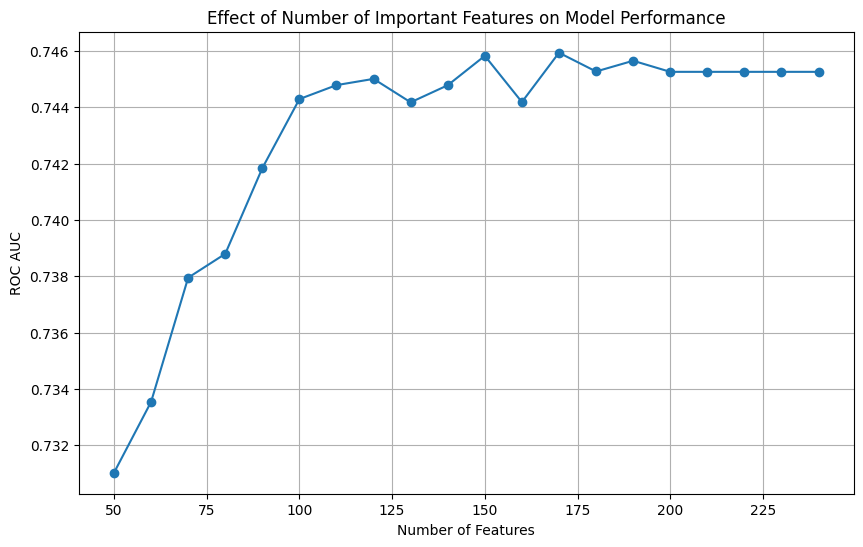

In [ ]:
# Получение средних абсолютных SHAP-значений для каждого признака
shap_importance = np.abs(shap_values).mean(axis=0)

# Создание DataFrame с важностью признаков
shap_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Importance': shap_importance
})

# Сортировка признаков по важности
shap_importance_df = shap_importance_df.sort_values(by='SHAP Importance', ascending=False)

# Диапазон количества признаков для проверки
num_features_range = range(50, 247, 10)  # Проверим от 50 до 247 признаков с шагом 10
roc_auc_scores = []

# Переменные для отслеживания лучшего результата
best_roc_auc = 0
best_num_features = 0

# Цикл по количеству признаков
for num_features in num_features_range:
    top_features = shap_importance_df['Feature'].head(num_features).tolist()

    # Применение маски к масштабированным данным
    X_train_selected = pd.DataFrame(X_train_scaled, columns=X.columns)[top_features]
    X_test_selected = pd.DataFrame(X_test_scaled, columns=X.columns)[top_features]

    # Обучение модели XGBoost на выбранных признаках
    model_selected = XGBClassifier(random_state=42, eval_metric='auc', use_label_encoder=False)
    model_selected.fit(X_train_selected, y_train)

    # Оценка модели на тестовых данных
    y_pred = model_selected.predict_proba(X_test_selected)[:, 1]
    roc_auc_selected = roc_auc_score(y_test, y_pred)
    roc_auc_scores.append(roc_auc_selected)

    print(f"ROC AUC с {num_features} признаками: {roc_auc_selected:.4f}")

    # Проверка, является ли текущий результат лучшим
    if roc_auc_selected > best_roc_auc:
        best_roc_auc = roc_auc_selected
        best_num_features = num_features

# Вывод наилучшего результата
print(f"\nНаилучший ROC AUC: {best_roc_auc:.4f} с {best_num_features} признаками")

# Построение графика зависимости ROC AUC от количества признаков
plt.figure(figsize=(10, 6))
plt.plot(num_features_range, roc_auc_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('ROC AUC')
plt.title('Effect of Number of Important Features on Model Performance')
plt.grid(True)
plt.show()

In [ ]:
# Сортировка признаков по важности
top_features = shap_importance_df['Feature'].head(150).tolist()
# Применение маски к масштабированным данным
X_train_selected = pd.DataFrame(X_train_scaled, columns=X.columns)[top_features]
X_test_selected = pd.DataFrame(X_test_scaled, columns=X.columns)[top_features]

In [ ]:
#признаки
top_features

['rn_count',
 'enc_loans_account_cur_avg',
 'pre_pterm_avg',
 'pre_loans_outstanding_avg',
 'pre_over2limit_max',
 'enc_loans_credit_status_avg',
 'enc_loans_credit_status_max',
 'pre_since_confirmed_median',
 'pre_pterm_median',
 'pre_loans530_max',
 'enc_loans_account_holder_type_avg',
 'pre_till_pclose_median',
 'pre_since_opened_avg',
 'pre_till_fclose_min',
 'is_zero_loans530_avg',
 'is_zero_util_avg',
 'pre_till_fclose_avg',
 'pre_util_max',
 'enc_loans_credit_type_max',
 'pre_till_fclose_median',
 'enc_paym_14_avg',
 'enc_paym_2_avg',
 'enc_loans_credit_type_median',
 'pre_over2limit_avg',
 'enc_paym_12_avg',
 'pre_util_min',
 'enc_paym_19_avg',
 'pre_loans_outstanding_max',
 'enc_loans_credit_type_min',
 'pre_since_opened_min',
 'pre_till_pclose_avg',
 'pre_since_opened_median',
 'pre_fterm_max',
 'pre_fterm_min',
 'enc_paym_3_avg',
 'enc_paym_16_avg',
 'pre_loans_credit_cost_rate_max',
 'pre_loans90_max',
 'pre_loans3060_avg',
 'pre_loans_credit_limit_max',
 'pre_loans_next_pa

## Поиск наилучших параметров модели


**Grid Search** и **Random Search** хороши для начального этапа или для небольших задач.

**Bayesian Optimization** и **Optuna** — мощные инструменты для сложных задач с большими пространствами параметров.
**Genetic Algorithms** подходят для задач, где другие методы не работают из-за сложной природы пространства параметров.

**Hyperband** и **Optuna** могут быть полезны, когда нужно быстро оценить и отобрать лучшие конфигурации.

**Рекомендации по выбору метода:**

Начальный этап: Random Search.
Ограниченные ресурсы: Bayesian Optimization или Hyperband.
Большое пространство параметров: Optuna или Genetic Algorithms.
Общая задача оптимизации: Bayesian Optimization или Optuna.

In [ ]:
# Определение параметров для оптимизации XGBoost
param_distributions_xgb = {
    'n_estimators': Integer(400, 1500),
    'max_depth': Integer(4, 6),
    'learning_rate': Real(0.001, 0.1, 'log-uniform'),
    'subsample': Real(0.7, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

# Инициализация модели XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='auc', verbosity=3, tree_method="hist")

# Байесовская оптимизация
opt_xgb = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_distributions_xgb,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=3
)

# Обучение модели
opt_xgb.fit(X_train_selected, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[04:18:59] ======== Monitor (0): HostSketchContainer ========
[04:18:59] AllReduce: 0.008104s, 1 calls @ 8104us

[04:18:59] MakeCuts: 0.008446s, 1 calls @ 8446us

[04:18:59] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[04:20:47] ======== Monitor (0): Learner ========
[04:20:47] Configure: 0.00137s, 1 calls @ 1370us

[04:20:47] EvalOneIter: 0.017123s, 1362 calls @ 17123us

[04:20:47] GetGra

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='auc', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=Non...
              search_spaces={'colsample_bytree': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.001, high=0.1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=4, high=6, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=400, high=1500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.7, high=1.0, prior='uniform', transform='normalize')},
              verbose=3)

In [ ]:
# Лучшие параметры
print(f"Лучшие параметры для XGBoost: {opt_xgb.best_params_}")

# Оценка модели на тестовых данных
best_model_xgb = opt_xgb.best_estimator_
preds_xgb = best_model_xgb.predict_proba(X_test_selected)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, preds_xgb)
print(f"XGBoost (с оптимизированными параметрами): ROC AUC = {roc_auc_xgb:.4f}")

Лучшие параметры для XGBoost: OrderedDict([('colsample_bytree', 0.8085396792511581), ('learning_rate', 0.035540927532494104), ('max_depth', 5), ('n_estimators', 1362), ('subsample', 0.8777859025916703)])
[04:20:47] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
XGBoost (с оптимизированными параметрами): ROC AUC = 0.7511


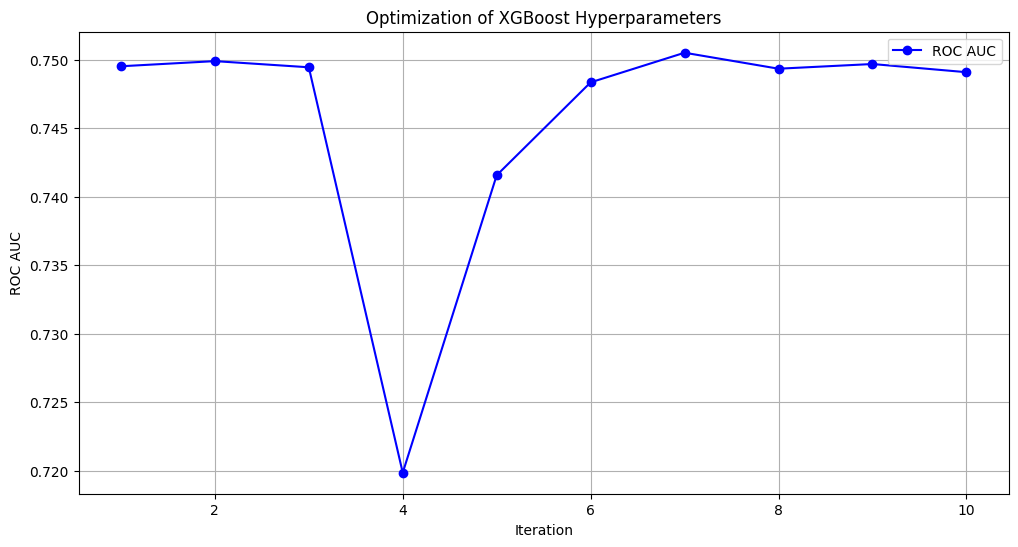

In [ ]:
# Построение графика оптимизации
results = opt_xgb.cv_results_
iterations = np.arange(1, len(results['mean_test_score']) + 1)
scores = results['mean_test_score']

plt.figure(figsize=(12, 6))
plt.plot(iterations, scores, marker='o', linestyle='-', color='b', label='ROC AUC')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
plt.title('Optimization of XGBoost Hyperparameters')
plt.legend()
plt.grid(True)
plt.show()

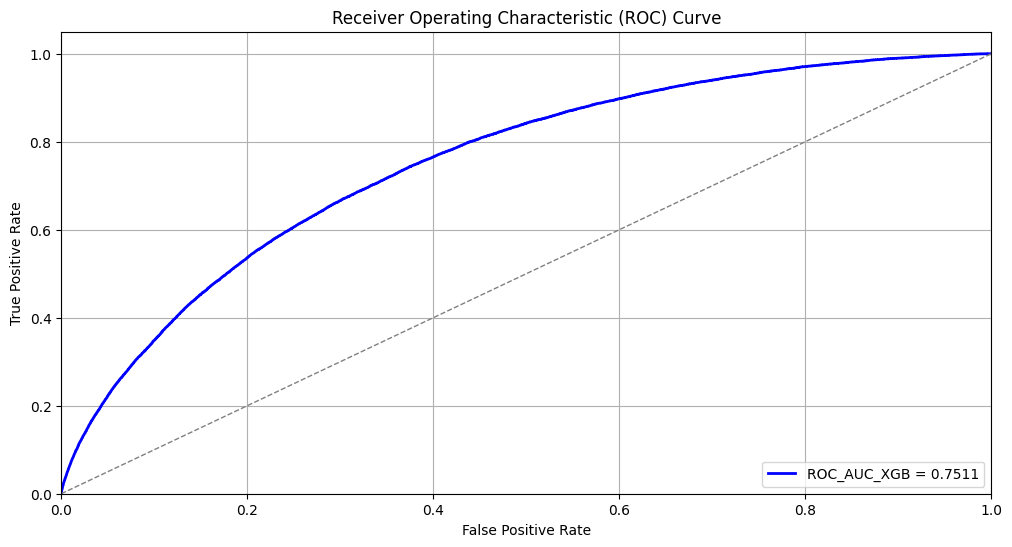

In [ ]:
from sklearn.metrics import roc_curve, auc
# Вычисление ROC-кривой и AUC
fpr, tpr, thresholds = roc_curve(y_test, preds_xgb)
roc_auc = auc(fpr, tpr)

# Построение графика ROC AUC
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC_AUC_XGB = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [15]:
# Сохранение обученной модели в файл
model_selected.save_model("xgb_model.json")
print("Ваша модель сохранена")

Ваша модель сохранена


In [16]:
# Загрузка модели из файла
loaded_model = XGBClassifier()
loaded_model.load_model("xgb_model.json")

XGBoost (с оптимизированными параметрами): ROC AUC = 0.7512
Оптимальный порог вероятности: 0.0351



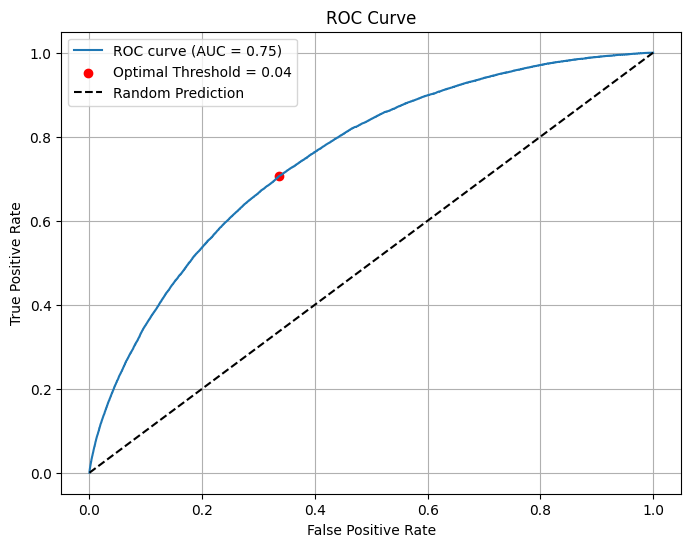

In [28]:
from sklearn.metrics import roc_curve

preds_xgb = loaded_model.predict_proba(X_test_selected)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, preds_xgb)
print(f"XGBoost (с оптимизированными параметрами): ROC AUC = {roc_auc_xgb:.4f}")

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, preds_xgb)

# Оптимальный порог — это тот, при котором максимизируется TPR - FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Оптимальный порог вероятности: {optimal_threshold:.4f}")
print()

# Визуализация ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

Оптимальный порог вероятности на основе F1-score: 0.0903



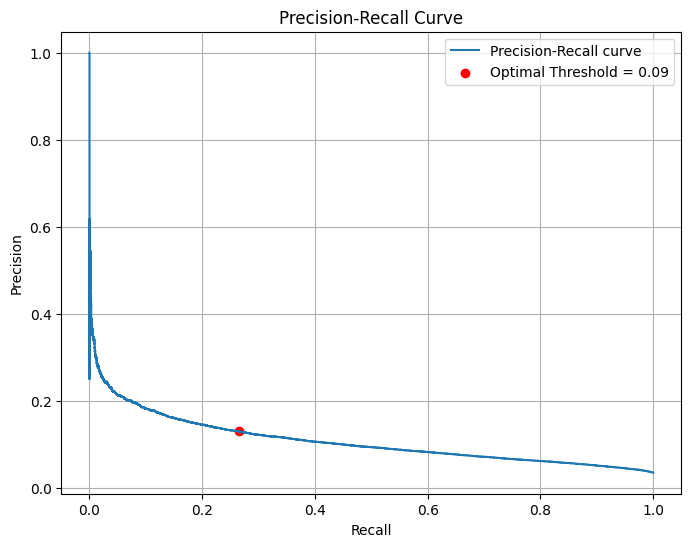

In [30]:
from sklearn.metrics import precision_recall_curve, f1_score

# Получение вероятностей для тестовых данных
y_pred_proba = model_selected.predict_proba(X_test_selected)[:, 1]

# Построение Precision-Recall кривой
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Рассчитываем F1-метрику для каждого порога
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Оптимальный порог вероятности на основе F1-score: {optimal_threshold:.4f}")
print()

# Визуализация Precision-Recall кривой
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

Оценка модели с помощью ROC AUC: помогает понять, насколько модель вообще способна различать дефолтеров от недефолтеров. Высокий ROC AUC говорит о том, что модель дает надежные вероятности, на основе которых можно принимать решения.

Оптимизация порога вероятности: В реальной задаче поиска дефолтов, мы должны выбрать такой порог вероятности, который будет оптимален для нашего бизнеса. Например:

Если порог слишком высокий (например, 0.5), мы можем упустить много дефолтеров.
Если порог слишком низкий (например, 0.2), мы можем пометить слишком много клиентов как дефолтеров, даже если они не являются таковыми (увеличивается количество ложных срабатываний).
Поиск оптимального порога:

Используем метрики, такие как Precision, Recall или F1-score, чтобы сбалансировать количество правильно и неправильно предсказанных дефолтов.
Построим ROC-кривую и выберем порог, который максимизирует соотношение между True Positive Rate (доля правильно предсказанных дефолтеров) и False Positive Rate (доля ложноположительных срабатываний).
Использование метрики ROC AUC в комбинации с другими метриками: ROC AUC дает общую картину о качестве модели, но для конкретных решений важно также анализировать Precision, Recall и F1-score при различных порогах.

Как ROC AUC помогает в задаче нахождения дефолтов?
Оценка модели: ROC AUC позволяет понять, насколько в принципе модель хороша для задачи поиска дефолтов.
Настройка порога: Оптимальный порог вероятности может быть найден на основе анализа ROC-кривой, Precision-Recall кривой и других метрик.
Заключение:
ROC AUC — это отличная метрика для оценки того, насколько наша модель способна различать классы. Однако, для задачи поиска дефолтов она работает в связке с порогом вероятности, который нужно оптимально подобрать. В нашем случае важно сначала оценить качество модели через ROC AUC, а затем провести анализ и найти такой порог вероятности, который будет наилучшим с точки зрения минимизации потерь или других бизнес-целей.

Порог по ROC-кривой (0.0351): Подходит, если цель — минимизировать количество пропущенных дефолтов, даже если при этом вы увеличите количество ложных срабатываний. Это может быть полезно в задачах, где важно обнаружить каждый возможный риск.
Порог по F1-score (0.0903): Подходит, если нам нужно сбалансировать точность и полноту, сохраняя приемлемое количество ложных срабатываний. Такой подход более взвешен и ориентирован на практическое применение модели.